##### Objectives:
- Reach 73% accuracy score or above when predicting if a customer is happy or not based on the answers they give to questions asked.
- What is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have?
- Is there any question that we can remove in our next survey?

##### Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers<br>
X1 = my order was delivered on time<br>
X2 = contents of my order was as I expected<br>
X3 = I ordered everything I wanted to order<br>
X4 = I paid a good price for my order<br>
X5 = I am satisfied with my courier<br>
X6 = the app makes ordering easy for me<br>

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

##### Hypothesis:

Based on the description of each attribute,
- X3 seems least relevant to customer satisfaction.
- X1 would be most relevant to customer satisfaction as the company is in the logistics and delivery domain.
- X5 could also be important in predicting customer satisfaction for the same reason mentioned above.

1. Load libraries and initialize variables.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from skfeature.function.similarity_based import fisher_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from scipy import stats
from scipy.stats.contingency import expected_freq
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

random_state = 1

In [2]:
survey_df = pd.read_csv("./data/ACME-HappinessSurvey2020.csv")
print(survey_df.head(), "\n")
print(survey_df.info(), "\n")
survey_df.describe()

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
None 



,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


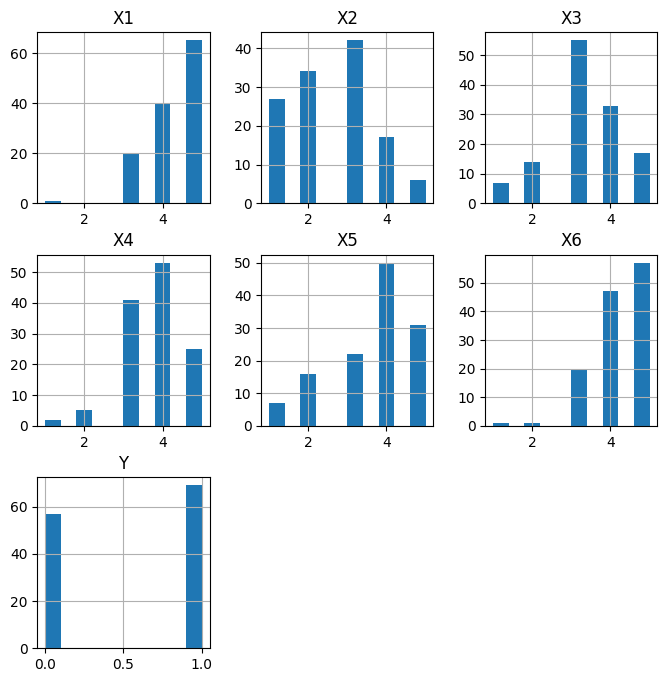

In [3]:
survey_df.iloc[:, [1,2,3,4,5,6,0]].hist(figsize=(8,8));

In [4]:
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(survey_df.drop("Y", axis=1), survey_df["Y"])

In [5]:
sample_df = pd.concat([X_balanced, y_balanced], axis=1).sample(n=1000, replace=True, random_state=random_state)
sample_df.describe()

,X1,X2,X3,X4,X5,X6,Y
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.29000,2.585000,3.322000,3.778000,3.653000,4.227000,0.525000
std,0.77492,1.065791,0.999658,0.812019,1.125992,0.784912,0.499624
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4.00000,2.000000,3.000000,3.000000,3.000000,4.000000,0.000000
50%,4.00000,3.000000,3.000000,4.000000,4.000000,4.000000,1.000000
75%,5.00000,3.000000,4.000000,4.000000,4.000000,5.000000,1.000000
max,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


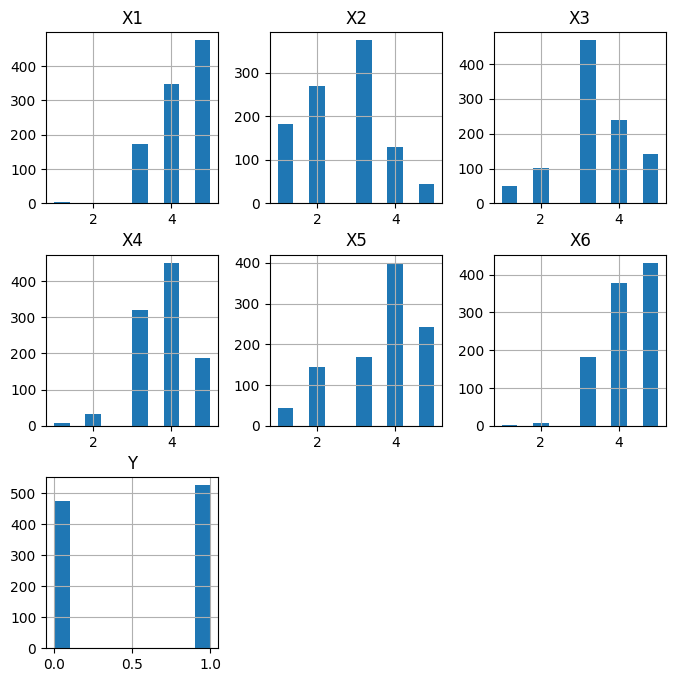

In [6]:
sample_df.hist(figsize=(8,8));



Y     0    1
X1          
1     4    0
3   107   66
4   228  120
5   136  339
Y          0         1
X1                    
1   1.274972 -1.212164
3   2.743758 -2.608592
4   4.884403 -4.643783
5  -5.960702  5.667060


Y     0    1
X2          
1    89   93
2    97  173
3   205  169
4    68   61
5    16   29
Y          0         1
X2                    
1   0.274257 -0.260870
2  -2.759442  2.624753
3   2.051988 -1.951830
4   0.859114 -0.817180
5  -1.162587  1.105841


Y     0    1
X3          
1    27   22
2    56   46
3   268  200
4    74  166
5    50   91
Y          0         1
X3                    
1   0.772114 -0.734427
2   1.084676 -1.031733
3   3.065113 -2.915504
4  -3.746343  3.563483
5  -2.074213  1.972970


Y     0    1
X4          
1     0    7
2    29    5
3   156  165
4   217  233
5    73  115
Y          0         1
X4                    
1  -1.623146  1.544733
2   3.194445 -3.040122
3   0.278572 -0.265114
4   0.214161 -0.203815
5  -1.729634  1.646076


Y     0    1
X5   

,pearson_r,pearson_p,spearman_rho,spearman_p,kendall_tau,kendall_p
X1,0.312192,4.795208e-24,0.332546,3.017100e-27,0.316233,7.705180e-26
X2,-0.041591,1.887943e-01,-0.061750,5.092274e-02,-0.056383,5.096993e-02
X3,0.178273,1.379118e-08,0.198935,2.202049e-10,0.183311,3.221432e-10
X4,0.087713,5.509809e-03,0.088197,5.254758e-03,0.082768,5.309350e-03
X5,0.235182,4.931058e-14,0.232145,1.056352e-13,0.212100,2.178060e-13
X6,0.257358,1.363877e-16,0.251486,6.869113e-16,0.238300,1.884758e-15


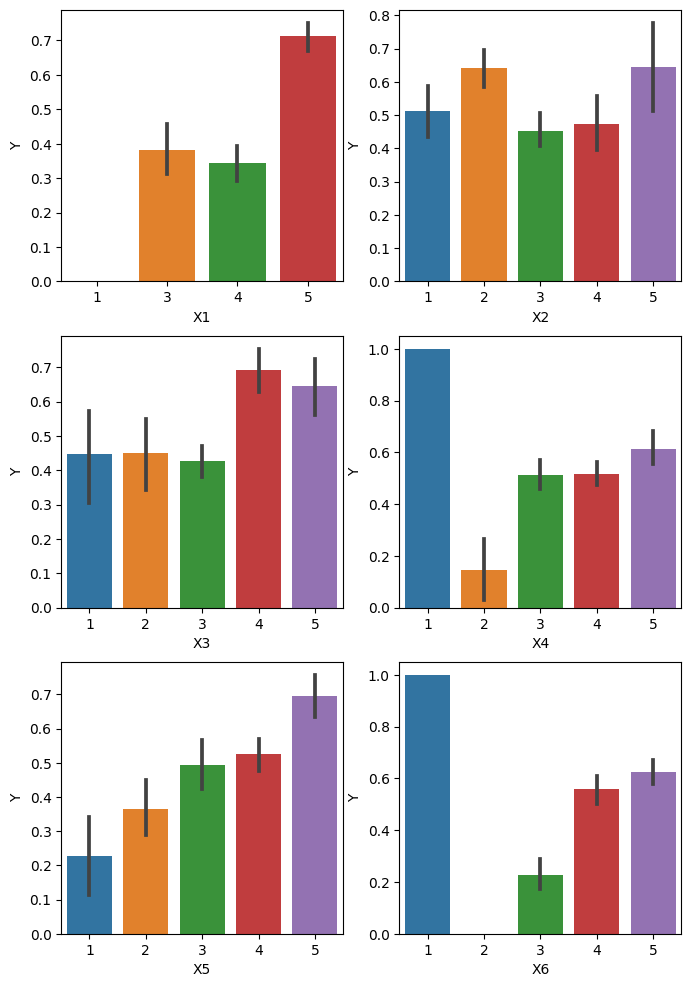

In [7]:
corr_df = pd.DataFrame(columns=["pearson_r", "pearson_p",
                                "spearman_rho", "spearman_p",
                                "kendall_tau", "kendall_p"])
fig, axes = plt.subplots(3, 2, figsize=(8,12))
for i, col in enumerate(sample_df.drop("Y", axis=1).columns):
    sns.barplot(sample_df, x=col, y="Y", ax=axes[i//2, i%2])
    x = sample_df[col]
    y = sample_df["Y"]
    print("\n")

    contingency_table = pd.crosstab(x, y)
    # expected_frequencies = expected_freq(contingency_table)
    print(contingency_table)
    # print(expected_frequencies)
    
    table = sm.stats.Table(contingency_table)
    print(table.resid_pearson)

    # chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    # print(chi2, p, dof, expected)
    
    # print(stats.chisquare(x))

    # for power in [1, 0, -1/2, -1]:
    #     print(stats.power_divergence(x, lambda_=power))

    r, r_p = stats.pearsonr(x, y)
    rho, rho_p = stats.spearmanr(x, y)
    tau, tau_p = stats.kendalltau(x, y)
    corr_dict = {
        "pearson_r": r,
        "pearson_p": r_p,
        "spearman_rho": rho,
        "spearman_p": rho_p,
        "kendall_tau": tau,
        "kendall_p": tau_p}
    corr_df = pd.concat([corr_df, pd.DataFrame(corr_dict, index=[col])], axis=0)

corr_df

- Based on the correlation coefficients, X2 and X4 would not be very helpful when predicting Y.
- Based on residuals from the expected frequencies, X1 and X5 would be most relevant in predicting Y; their correlation coefficients with Y are also higher.
- Correlation coefficients of X3 and X6 with Y are also high.
##### Thus, it would be reasonable to train a model with features without X2 and X4.

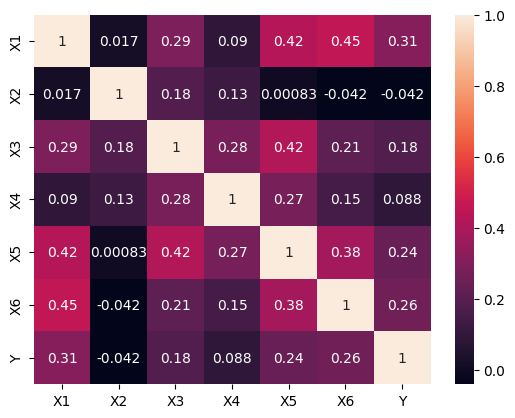

    information_gain  fisher_rank  feature_importance
X1          0.051892            1            0.185695
X3          0.044857            6            0.184776
X2          0.035071            5            0.170685
X5          0.006005            4            0.174201
X6          0.000000            2            0.134709
X4          0.000000            3            0.149935 

  information_gain fisher_rank feature_importance
0               X1          X1                 X1
1               X3          X6                 X3
2               X2          X4                 X5


In [8]:
def get_top_features(df, X, y, target_col="Y", top_n=3, random_state=1, show_heatmap=False, exclude_fisher_rank=False):
    # 1. Correlation with the target variable
    # plt.figure(figsize=(12,8))
    corr = df.corr()
    if show_heatmap:
        sns.heatmap(corr, annot=True)
        plt.show();
    
    scores_dicts = {}
    top_n_dicts = {}
    
    # corr_dict = {k: v for k, v in sorted(dict(corr[target_col].drop(target_col)).items(), key=lambda item: item[1], reverse=True)}
    # scores_dicts["correlation_coefficient"] = corr_dict
    # top_n_dicts["correlation_coefficient"] = list(corr_dict.keys())[:top_n]
    
    # 2. Information gain
    # Information gain calculates the reduction in entropy from the transformation of a dataset.
    # It can be used for feature selection by evaluating the Information gain of each variable 
    # in the context of the target variable.
    info_gain_scores = mutual_info_classif(X, y, random_state=random_state)
    info_gain = {col: info_gain_score for info_gain_score, col in zip(info_gain_scores, X.columns)}
    info_gain_sorted = {k: v for k, v in sorted(info_gain.items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["information_gain"] = info_gain_sorted
    top_n_dicts["information_gain"] = list(info_gain_sorted.keys())[:top_n]
    
    # 3. Fisher's score
    # Fisher score is one of the most widely used supervised feature selection methods.
    # The .fisher_score method will return fisher scores where the higher the score, the better.
    fisher_scores = fisher_score.fisher_score(X.to_numpy(), y)
    fisher_ranks = {col: 6 - fisher_score for fisher_score, col in zip(fisher_scores, X.columns)}
    fisher_ranks_sorted = {k: v for k, v in sorted(fisher_ranks.items(), key=lambda item: item[1])}
    if not exclude_fisher_rank:
        scores_dicts["fisher_rank"] = fisher_ranks_sorted
        top_n_dicts["fisher_rank"] = list(fisher_ranks_sorted.keys())[:top_n]
    
    # 4. Use a simple random forest model for evaluating feature importances, etc.
    random_forest = RandomForestClassifier(random_state=random_state)
    random_forest.fit(X, y)
    feature_importances = random_forest.feature_importances_
    feature_importance = {col: feature_importance for feature_importance, col in zip(feature_importances, X.columns)}
    feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["feature_importance"] = feature_importance_sorted
    top_n_dicts["feature_importance"] = list(feature_importance_sorted.keys())[:top_n]
    
    if exclude_fisher_rank:
        scores_df = pd.DataFrame(scores_dicts).sort_values(
            ['information_gain', 'feature_importance'], ascending=[False, False])
    else:
        scores_df = pd.DataFrame(scores_dicts).sort_values(
            ['information_gain', 'fisher_rank', 'feature_importance'], ascending=[False, True, False])
    top_n_df = pd.DataFrame(top_n_dicts)
    
    return scores_df, top_n_df

scores_df, top_n_df = get_top_features(sample_df, X_balanced, y_balanced, "Y", show_heatmap=True)
print(scores_df, "\n")
print(top_n_df)

Since information gain and feature importance scores are not fixed due to randomness, get the scores 100 times to see which features are generally more important regardless of randomness.

In [38]:
X_sampled = sample_df.drop("Y", axis=1)
y_sampled = sample_df["Y"]

In [39]:
top_n_dfs = pd.DataFrame()
for i in range(100):
    _, top_n_df = get_top_features(sample_df, X_sampled, y_sampled, random_state=i+1, exclude_fisher_rank=True)
    top_n_dfs = pd.concat([top_n_dfs, top_n_df])

top_n_occurrence = defaultdict(int)
for i in range(len(top_n_dfs.columns)):
    col_dict = top_n_dfs.iloc[:,i].value_counts().to_dict()
    for k, v in col_dict.items():
        top_n_occurrence[k] += v

top_n_occurrence = dict(sorted(top_n_occurrence.items(), key=lambda item: item[1]))
top_n_occurrence

{'X4': 12, 'X5': 47, 'X6': 94, 'X2': 107, 'X3': 141, 'X1': 199}

Based on information gain and feature importance scores, X1 and X5 are still found to be the most importance features.
However, X2 was ranked in top 3 more often than X6, while the correlation coefficient of X6 was higher than X2. 

In [14]:
def get_mean_accuracy_scores(X, y, columns, n=100, test_size=0.2):
    random_state = random.randint(1,100)
    
    # Choose a simple model as the base model since the data is not complex.
    base_model=LogisticRegression(random_state=random_state)
    accuracy_scores = []
    for i in range(n):
        _X = X[columns]
        X_train, X_test, y_train, y_test = \
            train_test_split(_X, y, test_size=test_size, random_state=random_state)
            
        base_model.fit(X_train, y_train)
        y_pred = base_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    print(f"Mean accuracy score with columns {columns}: {round(np.mean(accuracy_scores), 2)}")

In [40]:
for col in X_sampled.columns:
    columns = list(X_sampled.columns)
    columns.remove(col)
    get_mean_accuracy_scores(X_sampled, y_sampled, columns)

Mean accuracy score with columns ['X2', 'X3', 'X4', 'X5', 'X6']: 0.86
Mean accuracy score with columns ['X1', 'X3', 'X4', 'X5', 'X6']: 0.88
Mean accuracy score with columns ['X1', 'X2', 'X4', 'X5', 'X6']: 0.86
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X5', 'X6']: 0.93
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X4', 'X6']: 0.92
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X4', 'X5']: 0.93


In [41]:
for col in X_sampled.columns:
    get_mean_accuracy_scores(X_sampled, y_sampled, [col])

Mean accuracy score with columns ['X1']: 0.64
Mean accuracy score with columns ['X2']: 0.6
Mean accuracy score with columns ['X3']: 0.58
Mean accuracy score with columns ['X4']: 0.54
Mean accuracy score with columns ['X5']: 0.58
Mean accuracy score with columns ['X6']: 0.6


In [42]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=random_state)

In [43]:
tuned_model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.4, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=60,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.855

In [23]:
def randomized_search(model, X_train, y_train, params, scoring="accuracy", random_state=1, test_size=0.2):
    sss = StratifiedShuffleSplit(random_state=random_state, test_size=test_size) # n_splits=10 by default
    best_searched = RandomizedSearchCV(estimator=model, param_distributions=params, cv=sss,
                                        scoring=scoring, random_state=random_state) # n_iter=10 by default
    best_searched.fit(X_train, y_train)
    return best_searched

In [33]:
params = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "tol": np.arange(0.0001, 1, 0.0001),
    "C": np.arange(0.0001, 1, 0.0001),
    "fit_intercept": [True, False],
    "intercept_scaling": np.arange(0.01, 1, 0.01),
    "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "l1_ratio": np.arange(0.01, 1, 0.01)
}

base_model=LogisticRegression(random_state=random_state)
best_searched = randomized_search(base_model, X_train, y_train, params)
best_searched.best_estimator_, best_searched.best_score_, best_searched.best_params_

OverflowError: Python int too large to convert to C long

# Since feature selection is completed, split sample_df into train, validate, and test sets.
- Validate set will be used for model selection and hyperparameter tuning; since the data set is small and not very complex, a simple model like logistic regression might be more suitable than more complex models that could easily overfit.
- For more complex models, try regularization.
- Test set will only be used for evaluation of the hyperparameter-tuned model.

* https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets